In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Flight Network Analysis 

In [28]:
#Import the dataset
airports = pd.read_csv('Airports2.csv')

In [ ]:
airports.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

## Task 1 : Define the function "analyze_graph_features"

Implement a function analyze_graph_features(flight_network) that takes the flight network as input and computes the following:

* Count the number of airports (nodes) and flights (edges) in the graph.
* Compute the density of the graph using the formula: 
* Calculate both in-degree and out-degree for each airport and visualize them using histograms.
* Identify airports with degrees higher than the 90th percentile and list them as "hubs."
* Determine if the graph is sparse or dense based on its density.




In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def analyze_graph_features(flight_network):
    nodes = set(flight_network.nodes())
    #Count nodes and edges
    n_nodes = len(flight_network.nodes())
    n_edges = len(list(flight_network.edges()))
    
    #Density
    density = n_edges / (n_nodes * (n_nodes - 1)) if n_nodes > 1 else 0 #density for an oriented graph

    #In-degree and out-degree
    in_degrees = {node: 0 for node in nodes}
    out_degrees = {node: 0 for node in nodes}

    for origin, destination in flight_network.edges():
        out_degrees[origin] += 1
        in_degrees[destination] += 1

    #Plot degree distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees.values(), bins=20, color='skyblue', edgecolor='black')
    plt.title('In-degree distribution')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(out_degrees.values(), bins=20, color='salmon', edgecolor='black')
    plt.title('Out-degree distribution')
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    #Identify airports with degrees higher than the 90th percentile and list them as "hubs."
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in nodes}
    degree_threshold = np.percentile(list(total_degrees.values()), 90)
    hubs = [{"Airport": node,"Total degree": total_degrees[node],"In-degree": in_degrees[node],"Out-degree": out_degrees[node],}
        for node in nodes if total_degrees[node] > degree_threshold]
    hubs_dataframe = pd.DataFrame(hubs).sort_values(by="Total degree", ascending=False)

    #Determine if graph is sparse or dense
    graph_type = "dense" if density > 0.5 else "sparse"

    results = {
        "num_nodes": n_nodes,
        "num_edges": n_edges,
        "density": density,
        "hubs": hubs_dataframe,
        "graph_type": graph_type,
        "in_degrees": in_degrees,
        "out_degrees": out_degrees,
    }

    return results

## Task 2 : Define the function "summarize_graph_features"

Write a function summarize_graph_features(flight_network) that generates a detailed report of the graph's features. A summary report needs to include:

* The number of nodes and edges.
* The graph density
* Degree distribution plots for in-degree and out-degree.
* A table of identified hubs.

In [ ]:
def summarize_graph_features(features):
    print("Summary report")
    print(f"Number of nodes: {features['num_nodes']}")
    print(f"Number of edges: {features['num_edges']}")
    print(f"Graph density: {features['density']:.4f}")
    print(f"Graph type: {features['graph_type']}")
    print("\nHubs (Airports with degree > 90th percentile):")
    print(features['hubs'])


## Task 3 : Deeper Analysis

Now let's dive deeper into the analysis of the dataset. Do the following:

* Compute total passenger flow between origin and destination cities.
* Identify and visualize the busiest routes by passenger traffic.
* Calculate the average passengers per flight for each route and highlight under/over-utilized connections.
* Create an interactive map visualizing the geographic spread of the flight network.


In [ ]:
def analyze_routes(data):
    #Compute total passenger flow between origin and destination cities
    total_flow = data.groupby(['Origin_airport', 'Destination_airport', 'Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    total_flow = total_flow.sort_values(by='Passengers', ascending=False)

    #Calculate average passengers per flight
    flight_counts = data.groupby(['Origin_airport', 'Destination_airport'])['Flights'].sum().reset_index()
    total_flow = total_flow.merge(flight_counts, on=['Origin_airport', 'Destination_airport'])
    total_flow['Avg_Passengers_Per_Flight'] = total_flow['Passengers'] / total_flow['Flights']

    return pd.DataFrame(total_flow)


In [ ]:
#Plot the busiest routes by passenger flow
def plot_busiest_routes(total_flow):
    #Select the top 10 busiest routes by passenger flow
    top_routes = total_flow.head(10).copy()

    #Combine Origin and Destination into a single label
    top_routes['Route'] = (
        top_routes['Origin_airport'] + " (" + top_routes['Origin_city'] + ") → " +
        top_routes['Destination_airport'] + " (" + top_routes['Destination_city'] + ")"
    )

    # Plot the data
    plt.figure(figsize=(12, 8))
    plt.barh(top_routes['Route'], top_routes['Passengers'], color='orange')
    plt.xlabel("Total passengers")
    plt.ylabel("Routes")
    plt.title("Top 10 busiest routes by passenger flow")
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
#Plot top routes by passenger efficiency
def plot_top_efficiency_routes(total_flow):
    #Select the top 10 routes by passenger efficiency
    total_flow = total_flow.sort_values(by='Avg_Passengers_Per_Flight', ascending=False)
    top_efficiency_routes = total_flow.head(10).copy()

    #Combine Origin and Destination into a single label
    top_efficiency_routes['Route'] = (
        top_efficiency_routes['Origin_airport'] + " (" + top_efficiency_routes['Origin_city'] + ") → " +
        top_efficiency_routes['Destination_airport'] + " (" + top_efficiency_routes['Destination_city'] + ")"
    )

    #Plot the data
    plt.figure(figsize=(12, 8))
    plt.barh(top_efficiency_routes['Route'], top_efficiency_routes['Avg_Passengers_Per_Flight'], color='blue')
    plt.xlabel("Average passengers per flight")
    plt.ylabel("Routes")
    plt.title("Top 10 routes by passenger efficiency")
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
# Display the busiest routes as a table
def display_busiest_routes_table(total_flow):
    #Select the top 10 busiest routes by passenger flow
    top_routes = total_flow.head(10)[['Origin_airport', 'Origin_city', 'Destination_airport', 'Destination_city', 'Passengers']]
    print("\nTop 10 busiest routes by passenger flow:")
    print(top_routes.to_string(index=False))

# Display the most efficient routes as a table
def display_top_efficiency_routes_table(total_flow):
    #Select the top 10 routes by passenger efficiency
    total_flow = total_flow.sort_values(by='Avg_Passengers_Per_Flight', ascending=False)
    top_efficiency_routes = total_flow.head(10)[['Origin_airport', 'Origin_city', 'Destination_airport', 'Destination_city', 'Avg_Passengers_Per_Flight']]
    print("\nTop 10 routes by passenger efficiency:")
    print(top_efficiency_routes.to_string(index=False))

In [ ]:
def display_routes_analysis(total_flow):
    #Filter out the rows where Avg_Passengers_Per_Flight is 0 (to avoid flights with no passengers)
    total_flow = total_flow[total_flow['Avg_Passengers_Per_Flight'] > 0]
    
    #Display the quantiles to understand the thresholds for under-utilized and over-utilized routes
    lower_quantile = total_flow['Avg_Passengers_Per_Flight'].quantile(0.001)
    upper_quantile = total_flow['Avg_Passengers_Per_Flight'].quantile(0.999)
    
    #Recalculate the under-utilized and over-utilized routes for better control
    under_utilized = total_flow[total_flow['Avg_Passengers_Per_Flight'] < lower_quantile]
    over_utilized = total_flow[total_flow['Avg_Passengers_Per_Flight'] > upper_quantile]
    
    print("\nUnder-utilized Routes:")
    print(pd.DataFrame(under_utilized))
    
    print("\nOver-utilized Routes:")
    print(pd.DataFrame(over_utilized))
    

## Interactive map



In [ ]:
import folium
from folium.plugins import MarkerCluster

#Interactive map

def create_flight_network_map(data):
    # Initialize a folium map
    flight_map = folium.Map(location=[0, 0], zoom_start=2)
    marker_cluster = MarkerCluster().add_to(flight_map)

   #Add routes to the map
    for i, row in data.iterrows():
        #Skip rows with missing coordinates
        if pd.isna(row['Org_airport_lat']) or pd.isna(row['Org_airport_long']) or pd.isna(row['Dest_airport_lat']) or pd.isna(row['Dest_airport_long']):
            continue

        origin = [row['Org_airport_lat'], row['Org_airport_long']]
        destination = [row['Dest_airport_lat'], row['Dest_airport_long']]
    
        #Draw a line between origin and destination
        folium.PolyLine(locations=[origin, destination], color='blue', weight=2).add_to(flight_map)

        #Add markers for origin and destination
        folium.Marker(location=origin, popup=row['Origin_city']).add_to(marker_cluster)
        folium.Marker(location=destination, popup=row['Destination_city']).add_to(marker_cluster)
        
    return flight_map

In [ ]:
flight_map = create_flight_network_map(airports)
flight_map.save("flight_network.html")

## Results of Q1 : 

Expected Output:
Once you have created and tested the previous functions, the results should be presented in a tidy way. Your summary report should contain:

* The number of nodes and edges.
* The graph density.
* Degree distribution plots for in-degree and out-degree.
* A table of identified hubs.
* Top routes by passenger flow (table and bar chart).
* Top routes by passenger efficiency (table and bar chart).
* An interactive map showing flight routes.

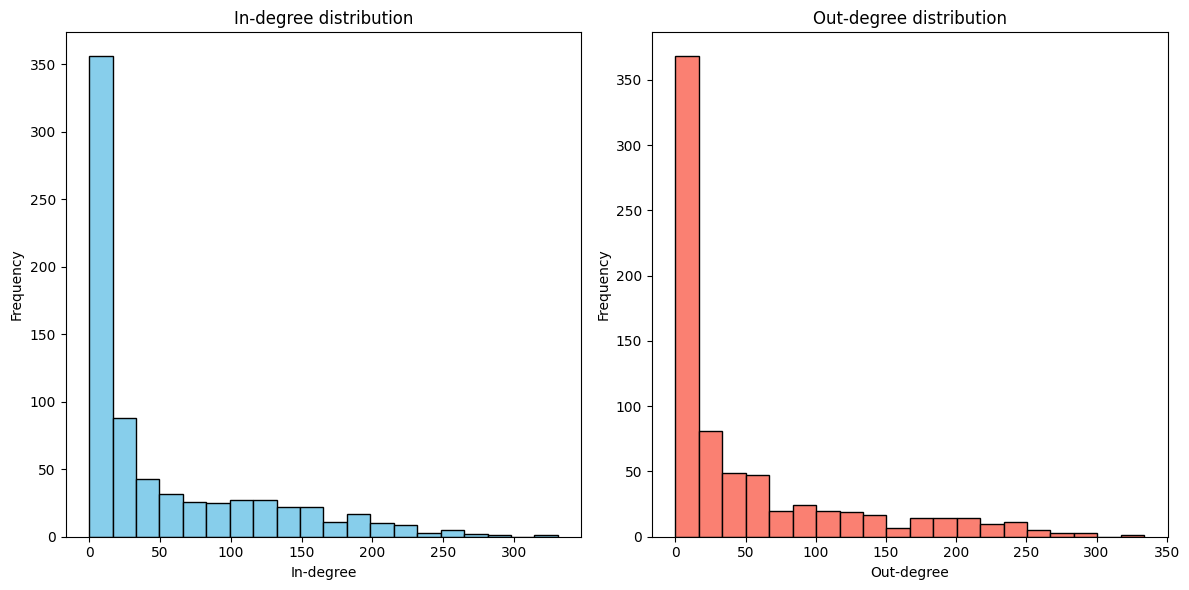

Summary report
Number of nodes: 727
Number of edges: 36719
Graph density: 0.0696
Graph type: sparse

Hubs (Airports with degree > 90th percentile):
   Airport  Total degree  In-degree  Out-degree
42     YIP           665        331         334
0      MSP           583        291         292
32     MEM           564        277         287
53     MCI           539        272         267
43     ATL           539        259         280
..     ...           ...        ...         ...
9      LGA           335        146         189
24     FWA           332        165         167
21     GRR           327        152         175
55     JAX           322        146         176
71     GSO           319        144         175

[73 rows x 4 columns]


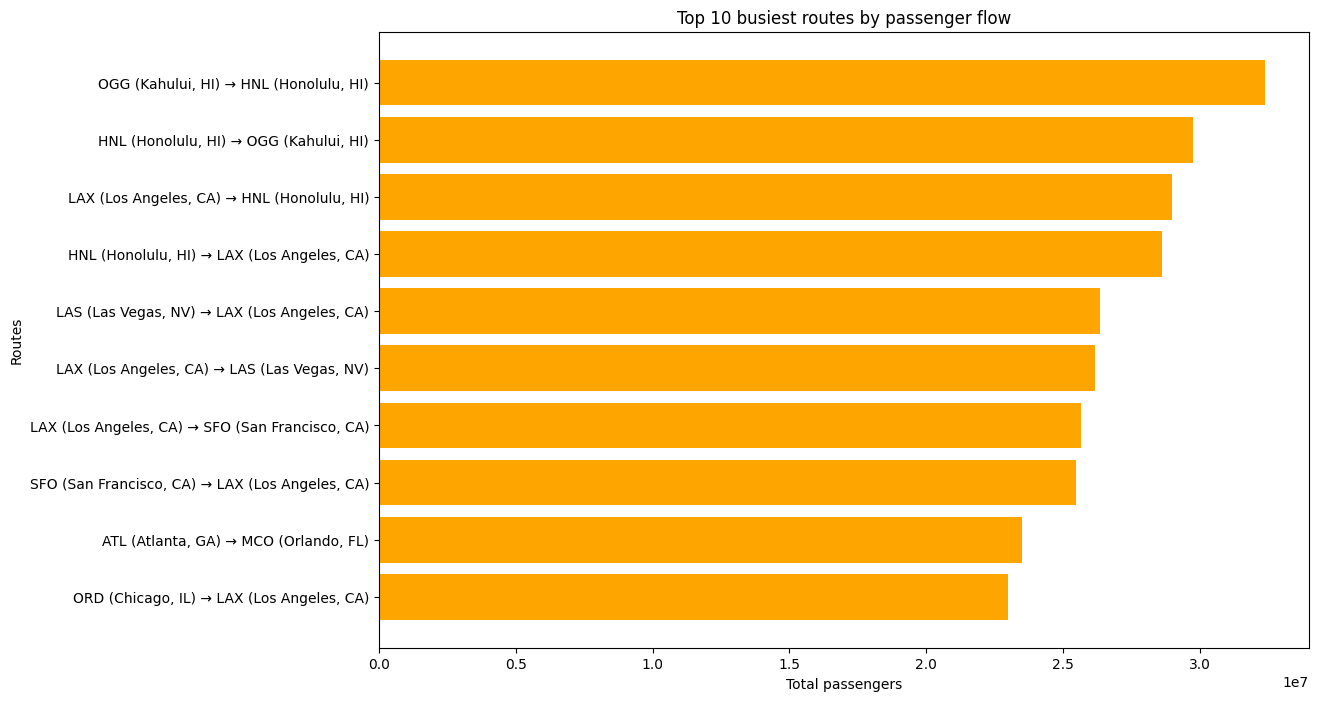

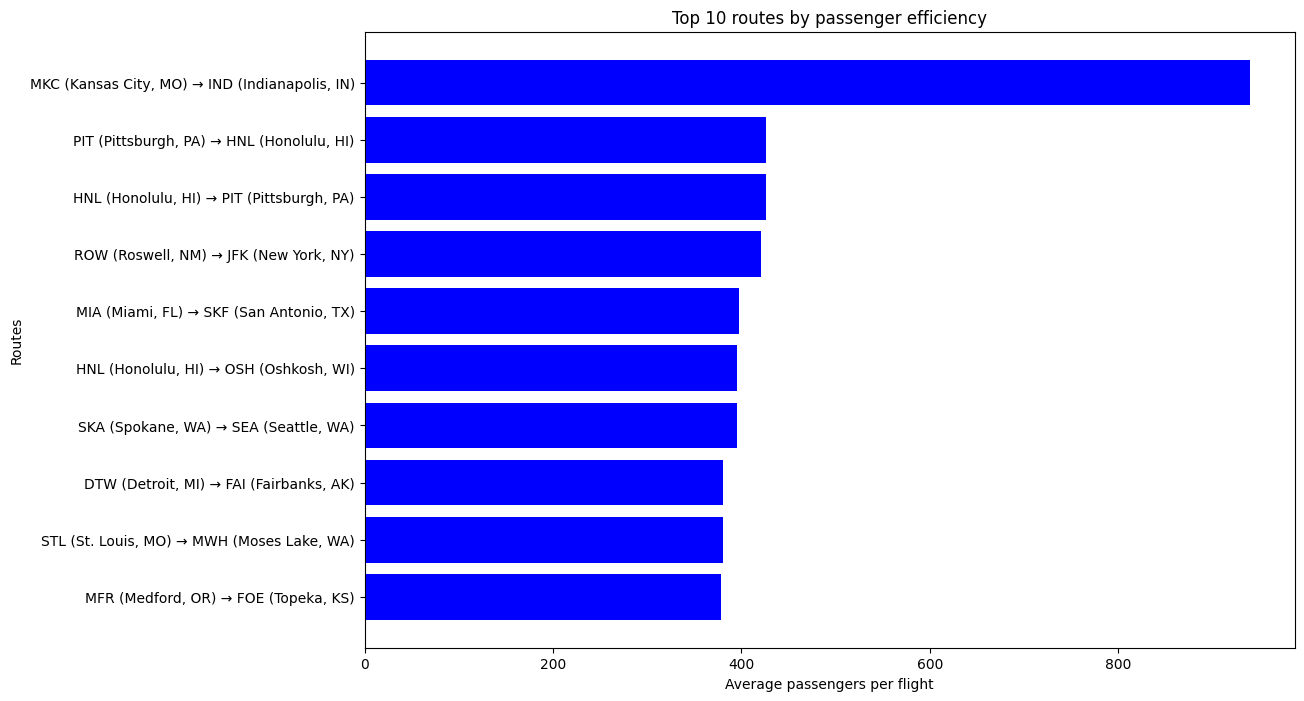


Top 10 busiest routes by passenger flow:
Origin_airport       Origin_city Destination_airport  Destination_city  Passengers
           OGG       Kahului, HI                 HNL      Honolulu, HI    32364612
           HNL      Honolulu, HI                 OGG       Kahului, HI    29744742
           LAX   Los Angeles, CA                 HNL      Honolulu, HI    28964154
           HNL      Honolulu, HI                 LAX   Los Angeles, CA    28632161
           LAS     Las Vegas, NV                 LAX   Los Angeles, CA    26333721
           LAX   Los Angeles, CA                 LAS     Las Vegas, NV    26177809
           LAX   Los Angeles, CA                 SFO San Francisco, CA    25661782
           SFO San Francisco, CA                 LAX   Los Angeles, CA    25458207
           ATL       Atlanta, GA                 MCO       Orlando, FL    23483751
           ORD       Chicago, IL                 LAX   Los Angeles, CA    22979359

Top 10 routes by passenger efficiency:
Origi

In [ ]:
# Construction of the graph
flight_network = nx.DiGraph()
for i, row in airports.iterrows():
    source = row['Origin_airport']
    destination = row['Destination_airport']
    flight_network.add_edge(source, destination)

# Analyze the graph
features = analyze_graph_features(flight_network)

# Display summary and hubs table
summarize_graph_features(features)

total_flow = analyze_routes(airports)

# Visualize the busiest routes
plot_busiest_routes(total_flow)

# Visualize top routes by efficiency
plot_top_efficiency_routes(total_flow)

display_busiest_routes_table(total_flow)
display_top_efficiency_routes_table(total_flow)

#Calculate the average passengers per flight for each route and highlight under/over-utilized connections
display_routes_analysis(total_flow)

In [ ]:
display_routes_analysis(total_flow)


Under-utilized Routes:
      Origin_airport Destination_airport       Origin_city  Destination_city  \
22002            SJT                 AUS    San Angelo, TX        Austin, TX   
22385            CIC                 SMF         Chico, CA    Sacramento, CA   
22484            GUP                 ABQ        Gallup, NM   Albuquerque, NM   
22915            EAT                 GEG     Wenatchee, WA       Spokane, WA   
23279            RFD                 EWR      Rockford, IL        Newark, NJ   
23341            EWN                 GSO      New Bern, NC    Greensboro, NC   
24536            ROW                 LBB       Roswell, NM       Lubbock, TX   
24548            BWI                 SBY     Baltimore, MD     Salisbury, MD   
24957            TOL                 RDU        Toledo, OH       Raleigh, NC   
24965            MHT                 MEM    Manchester, NH       Memphis, TN   
25141            GSO                 EWN    Greensboro, NC      New Bern, NC   
25256           

## Questions on the analysis : 

After completing the analysis, answer the following questions:

* **Is the graph sparse or dense?** The graph is sparse. With 727 nodes and 36,719 edges, the calculated graph density is 0.0696, which is far below 0.5. A sparse graph implies that only a small percentage of possible connections between nodes are actually realized, typical for flight networks where not all airports are directly connected.
  
* **What patterns do you observe in the degree distribution?** The degree distributions (both in-degree and out-degree) reveal that most airports have a relatively low number of connections, while a few airports have significantly higher degrees. This is a typical power-law distribution, where a small number of nodes (airports) act as hubs with many connections.
  
* **Which airports are identified as hubs, and why?** The airports are identified as hubs because their total degree (in-degree + out-degree) is higher than the 90th percentile threshold: these hubs likely serve as central nodes in the network due to their high traffic volume or their role in connecting many routes.
  
* **What are the busiest routes in terms of passenger traffic?**

  The busiest routes by passenger flow, based on the data provided, are:

1. OGG (Kahului, HI) to HNL (Honolulu, HI) – 32,364,612 passengers
2. HNL (Honolulu, HI) to OGG (Kahului, HI) – 29,744,742 passengers
3. LAX (Los Angeles, CA) to HNL (Honolulu, HI) – 28,964,154 passengers

These routes are the busiest based on the number of passengers traveling between these city pairs.
  
* **Which routes are under/over-utilized?**

**Under-utilized routes**

Routes with average passengers per flight < 0.01:

BWI → SBY (Baltimore, MD → Salisbury, MD): 0.008531
GSO → EWN (Greensboro, NC → New Bern, NC): 0.008290
CPR → RKS (Casper, WY → Rock Springs, WY): 0.007437
RFD → JFK (Rockford, IL → New York, NY): 0.007629
MHT → MEM (Manchester, NH → Memphis, TN): 0.007605
RFD → BOS (Rockford, IL → Boston, MA): 0.006689
RIW → CPR (Riverton, WY → Casper, WY): 0.005952

Routes with Extremely Low Utilization:

VIS → OAK (Visalia, CA → Oakland, CA): 0.002034
ALB → MEM (Albany, NY → Memphis, TN): 0.002830

**Over-utilized routes** 


Routes with average passenegers per flight > 300:

DTW → FAI (Detroit, MI → Fairbanks, AK): 380.8
MIA → SKF (Miami, FL → San Antonio, TX): 397.25
MCI → BGR (Kansas City, MO → Bangor, ME): 341.33
HNL → FAR (Honolulu, HI → Fargo, ND): 321.17
NZY → TPA (San Diego, CA → Tampa, FL): 316.33



# 2. Nodes' Contribution

### Centrality Analysis in a Flight Network

In this analysis, we explored the structural importance of airports within a flight network by calculating centrality measures for each node and visualizing key results. The following steps summarize the approach:

1. **`analyze_centrality(flight_network, airport)`**:  
   This function computes centrality measures for a specific airport using precomputed dictionaries for each metric:  
   - **Betweenness Centrality**: Measures how often the airport appears on the shortest paths between other airports. Calculated using `calculate_betweenness_centrality`.  
   - **Closeness Centrality**: Quantifies how efficiently an airport can reach all other nodes. Calculated using `calculate_closeness_centrality`.  
   - **Degree Centrality**: Simply counts the number of direct connections (neighbors) an airport has. Calculated using `numbers_neighbors`.  
   - **PageRank**: Assesses the "importance" of an airport based on its incoming connections and their weights. Calculated using `calculate_pagerank`.

2. **Visualization with `plot_top_metric`**:  
   We used the `plot_top_metric` function to focus on the top 5 airports for any given centrality metric.  
   This function creates a bar plot showing the airports with the highest values for a specified metric, helping to visually identify the most influential nodes in the network.

By combining these tools, the analysis provides both numerical results for individual airports and visual insights into the most critical nodes across the network.

In [27]:
import Functions.centrality as cn
from scipy.stats import pearsonr

First of all we create two graph, one directed and one undirected, both of them weighted using the number of passeners

In [30]:
# Creating our weights
edge_weights = airports.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()


# Creatign directed weighted graph 
G_dir = nx.DiGraph()

for i, row in edge_weights.iterrows():
    source = row['Origin_airport']
    destination = row['Destination_airport']
    passengers = row['Passengers']

    G_dir.add_edge(source, destination, weight=passengers)


# Creating undirected weighted graph

G_no_dir = nx.Graph()

for i, row in edge_weights.iterrows():
    source = row['Origin_airport']
    destination = row['Destination_airport']
    passengers = row['Passengers']

    G_no_dir.add_edge(source, destination, weight=passengers)


In [31]:
# Computing all the dictionaries with the metrics for each airport, and a df with the metrics for the requested airport
centrality_df, betweenness_centr, closeness_centrality, degree_centrality, pageranks = cn.analyze_centrality(G_dir, G_no_dir, 'BOS')

In [32]:
# DataFrame with metrics for the airport
centrality_df

,Airport,Betweenness Centrality,Betweenness Percentile,Closeness Centrality,Closeness Percentile,Degree Centrality,Degree Percentile,Pagerank,Pagerank Percentile
0,BOS,0.014314,96.973865,0.591205,95.185695,228,96.286107,0.012107,97.661623


Here we can see an exemple for the metric for an airport that we wanted to analyze. Furthermore, we have also added the percentile of the metric of the airport in question compared to those of all the other airports, in order to have a clearer idea of ​​the actual 'centrality' of the airport compared to all the others. The numbers of the metrics alone would otherwise be slightly complicated to interpret.

We can see how the dictionary with all the metrics looks for some elements.

In [33]:
# A part of the dictonary about betweenness_centr
list(betweenness_centr.items())[:10]

[('1B1', 0.0),
 ('BDL', 0.007347079814267677),
 ('ABE', 0.0007723942108939866),
 ('ACT', 0.002796665678965417),
 ('ACY', 0.003866789056754446),
 ('ADS', 0.0024138391176673703),
 ('AGS', 0.0009312824129212785),
 ('ALB', 0.0052663116853228185),
 ('ATL', 0.02300317991035096),
 ('ATW', 0.001318232701319797)]

In [34]:
# A part of the dictonary about closeness_centrality
list(closeness_centrality.items())[:10]

[('1B1', 0.3631815907953977),
 ('BDL', 0.5698587127158555),
 ('ABE', 0.5260869565217391),
 ('ACT', 0.5458646616541354),
 ('ACY', 0.5226781857451404),
 ('ADS', 0.5397769516728624),
 ('AGS', 0.5377777777777778),
 ('ALB', 0.5377777777777778),
 ('ATL', 0.6264020707506471),
 ('ATW', 0.5276162790697675)]

In [35]:
# A part of the dictonary about degree_centrality
list(degree_centrality.items())[:10]

[('1B1', 1),
 ('BDL', 182),
 ('ABE', 121),
 ('ACT', 110),
 ('ACY', 118),
 ('ADS', 102),
 ('AGS', 88),
 ('ALB', 133),
 ('ATL', 280),
 ('ATW', 97)]

In [36]:
# A part of the dictonary about pageranks
list(pageranks.items())[:10]

[('1B1', 0.00021777821443501834),
 ('BDL', 0.0035003542345025495),
 ('ABE', 0.0008541150722050301),
 ('ACT', 0.0004019014998425109),
 ('ACY', 0.0013308256475267086),
 ('ADS', 0.00021784121937951906),
 ('AGS', 0.00047318699139550465),
 ('ALB', 0.0017658467321843836),
 ('ATL', 0.03800917594696437),
 ('ATW', 0.0005190523098735411)]

Now that we have an idea we can go and see which airports occupy the first 5 positions for each metric, so which are the most central for each evaluation metric that we have implemented.

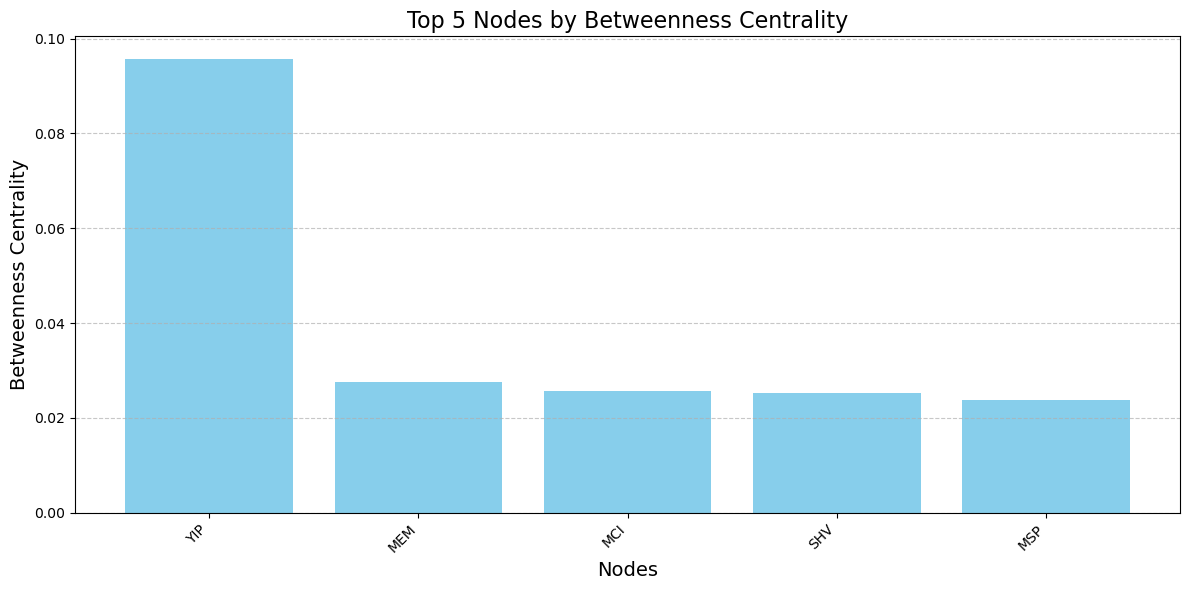

In [37]:
cn.plot_top_metric(betweenness_centr, 'Betweenness Centrality', top_n = 5)

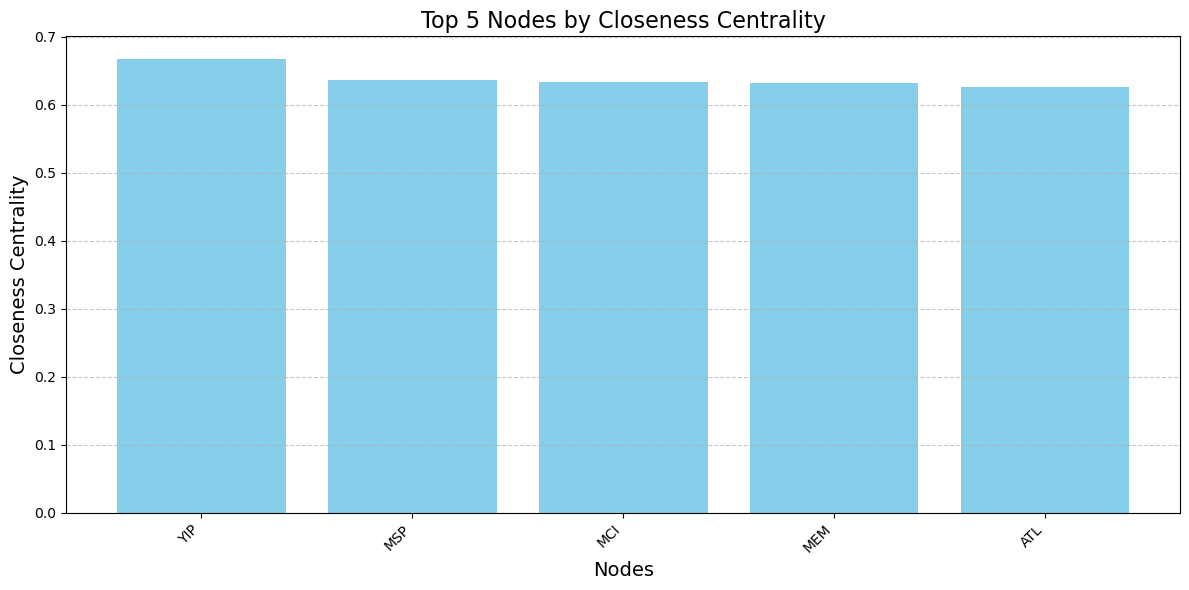

In [62]:
cn.plot_top_metric(closeness_centrality, 'Closeness Centrality', top_n= 5)

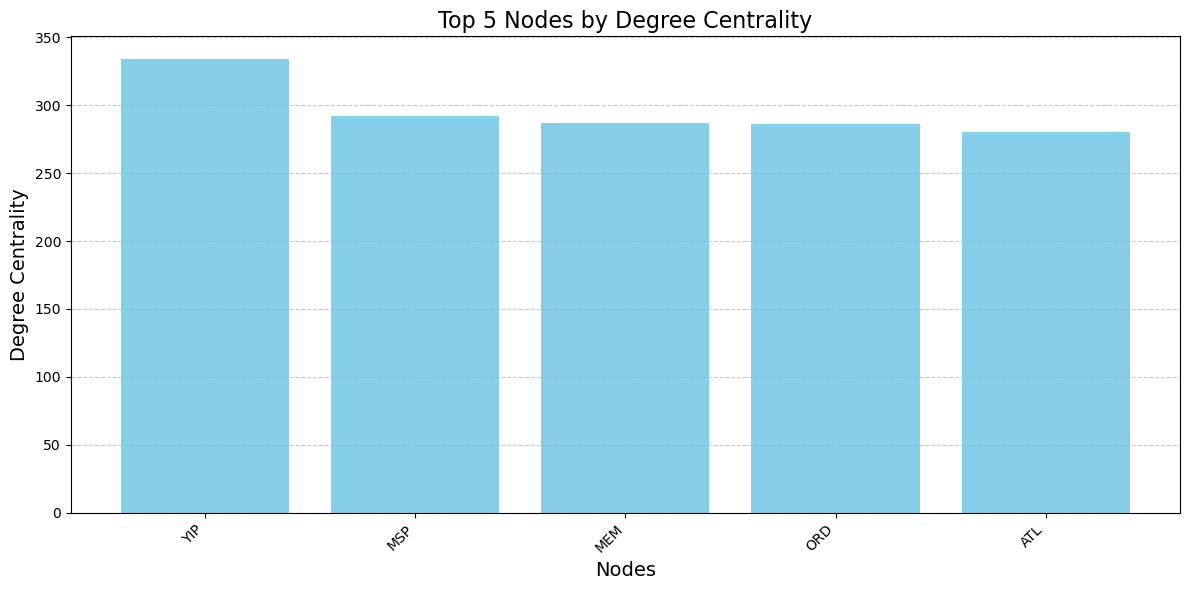

In [63]:
cn.plot_top_metric(degree_centrality, 'Degree Centrality', top_n=5)

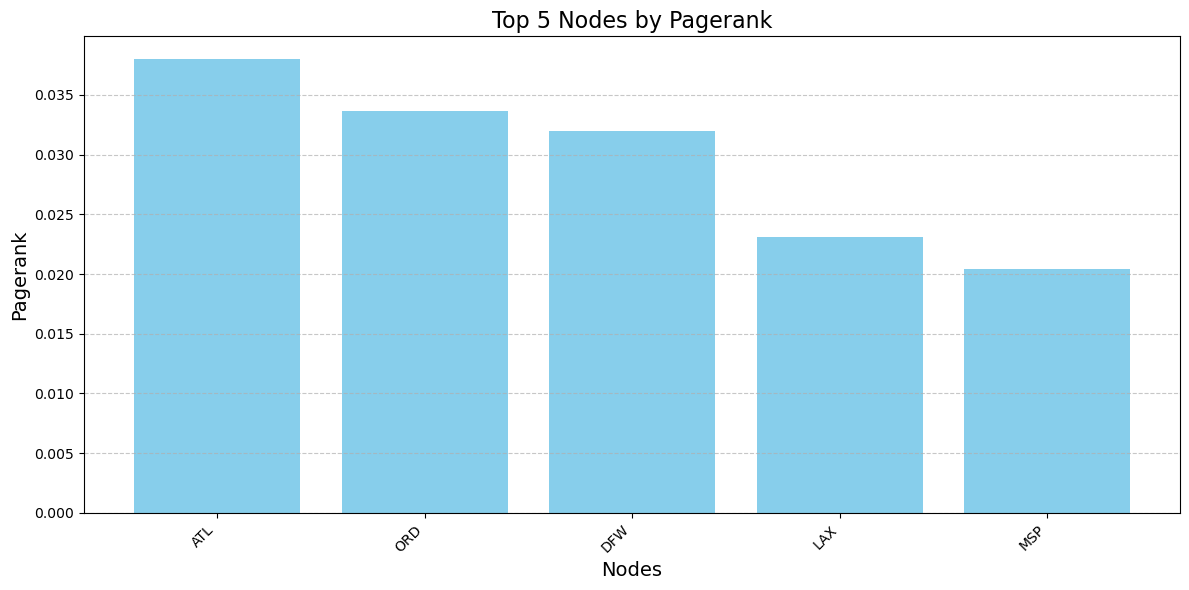

In [64]:
cn.plot_top_metric(pageranks, 'Pagerank', top_n= 5 )

### LLM questions 

Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

#### Here are some alternative centrality measures that might be relevant for analyzing the airport network:

- Eigenvector Centrality:
    Measures how important a node is based on the importance of its neighbors.
    Particularly useful when certain airports are connected to other "high-rank" airports.

- Katz Centrality:
    Similar to Eigenvector Centrality, but assigns decreasing importance to connections further away.
    Useful for capturing the influence of airports that are not directly connected.

- Harmonic Centrality:
    A variation of Closeness Centrality that better handles disconnected graphs by calculating the reciprocal of the distance only for reachable nodes.
    Useful when the network contains isolated sub-networks.

- Flow Centrality:
    Measures how critical a node is in facilitating flows (e.g., passengers or goods) across the network.
    Relevant for analyzing how traffic moves through airports.

- Edge Betweenness Centrality:
    Calculates centrality for edges (connections) rather than nodes.
    Helps identify critical routes that, if removed, would disrupt traffic between regions of the network.

#### How to Check if the Results are Trustworthy

- Compare with Other Studies:
    Look for academic papers or reports related to the analysis of similar networks (transportation, infrastructure, etc.).
    Verify if the suggested measures align with those used in previous studies.

- Intuitive Analysis and Interpretation:
    Each centrality measure should have a clear interpretation in the context of the airport network. For example:
        Eigenvector Centrality should identify airports with highly strategic connections.
        Flow Centrality should highlight airports critical for passenger transit.

- Statistical Validation:
    Apply the new centrality measures to the network and compare the results with already computed ones (Betweenness, Closeness, Degree, PageRank).
    Check for significant correlations or differences:
        Compute correlation coefficients (e.g., Pearson or Spearman) between the centralities.

- Network Experiments:
    Remove nodes or edges with high centrality (according to the new measure) and observe the impact on network connectivity or capacity.
    If significant impacts are observed, it supports the relevance of the measure.

- Consult Domain Experts:
    Seek feedback from experts in airport networks or transportation to evaluate the validity of the suggested measures in a real-world context.

In [6]:
# Calculate Flow Centrality
flow_centrality = cn.calculate_flow_centrality(G_no_dir)

# Output the Flow Centrality scores for a semple of nodes 
print("Flow Centrality:")
list(flow_centrality.items())[:10]

Flow Centrality:


[('LOZ', 0.0),
 ('LSE', 0.02174218675786074),
 ('EDF', 0.008929419587726799),
 ('SWW', 0.0),
 ('NGP', 0.0),
 ('CEC', 0.004593901396409234),
 ('BYH', 0.0034577752446091005),
 ('FLG', 0.009856559323643963),
 ('ATW', 0.0458098223615465),
 ('EUG', 0.08796048256863305)]

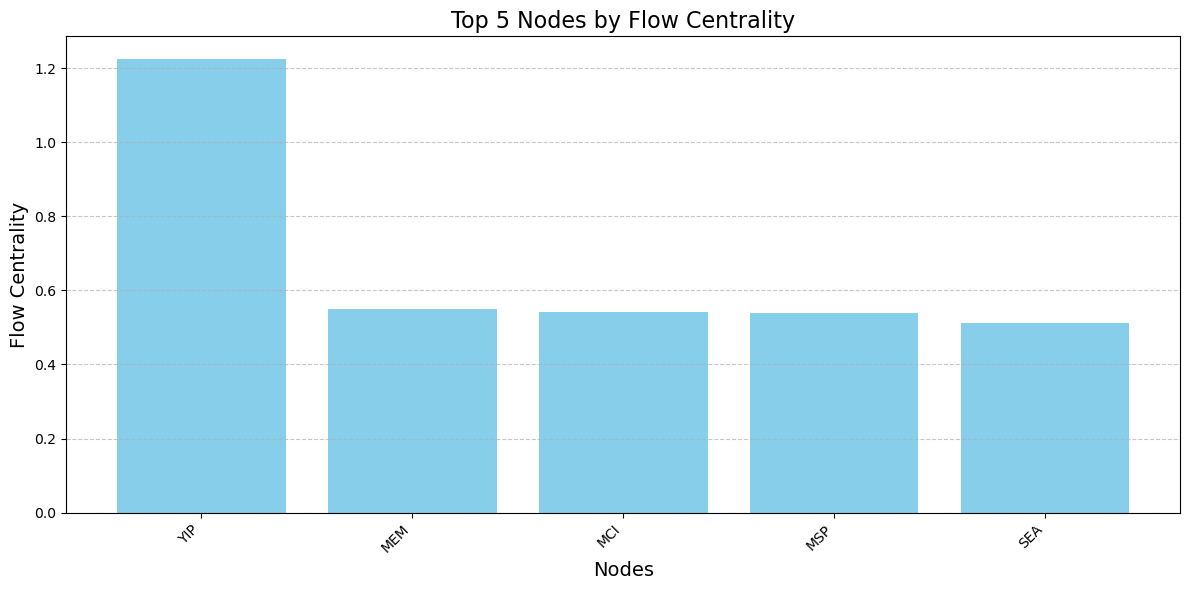

In [7]:
cn.plot_top_metric(flow_centrality, 'Flow Centrality', top_n = 5)

### Similarities and Differences between Flow Centrality and Betweenness Centrality

Both **Flow Centrality** and **Betweenness Centrality** measure the importance of a node in terms of its involvement in the shortest paths between other nodes. The key similarity is that they both focus on how often a node appears on the shortest paths in the graph, which reflects the node's centrality and influence on communication within the network.

#### Differences:
- **Flow Centrality** counts how many times a node appears in the shortest paths between all pairs of nodes, without considering the control or flow of information. It's a simpler measure, focusing solely on frequency of appearance.
- **Betweenness Centrality**, on the other hand, measures how often a node acts as a bridge, influencing the flow between other nodes. It takes into account the dependency of other nodes' paths on the node in question.

Because of these differences in focus and complexity, **Flow Centrality** will be compared with **Betweenness Centrality** to assess the nuances in how each metric captures node importance.
We can start computing the Correlation, as suggested before with statistical validations.

In [22]:
metrics = pd.DataFrame({
    'airport': list(flow_centrality.keys()),
    'flow_centrality': list(flow_centrality.values()),
    'betweenness_centrality': list(betweenness_centr.values())
})

correlation, p_value = pearsonr(metrics['flow_centrality'], metrics['betweenness_centrality'])

print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson Correlation: 0.9293056049563915
P-value: 7.299557e-316
The correlation is statistically significant.


As we could immagine, the correlation is very high, that means that those metrics are really similar. We can try to see the differences between them by having a graphical representation of their distributions with two histograms.

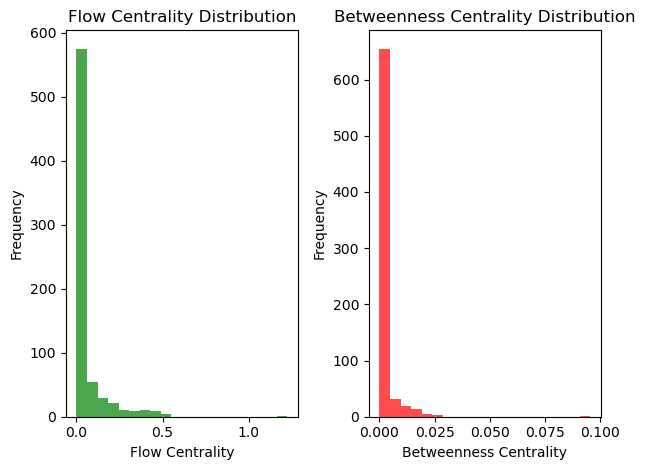

In [19]:
# Histogram for Flow Centrality
plt.subplot(1, 2, 1)
plt.hist(metrics['flow_centrality'], bins=20, color='green', alpha=0.7)
plt.title('Flow Centrality Distribution')
plt.xlabel('Flow Centrality')
plt.ylabel('Frequency')

# Histogram for Betweenness Centrality
plt.subplot(1, 2, 2)
plt.hist(metrics['betweenness_centrality'], bins=20, color='red', alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From this graph one thing is clear, the distributions are almost identical, this confirms the high correlation, that is, the values ​​tend to move in step. But paying attention to the values ​​on the x, we can notice how for both the concentration is high for the values ​​close to zero, but for the Flow Centrality the values ​​go up to larger numbers, unlike the Betweenness Centrality which has more contained values.
Just observe that the highest value for both is the same, the YIP airport, but it has a Flow Centrality of about 1.2, and a Betweenness Centrality equal to just under 0.1. The other values ​​in the Flow slightly exceed 0.5, while in the Betweenness they barely exceed 0.025.

# 3. Finding Best Routes 

In [ ]:
import heapq
from collections import defaultdict

def find_best_routes(airports, origin_city, destination_city, date):
    #Filter flights by date
    filtered_flights = airports[airports['Fly_date'] == date]
    
    #Construction of graphs
    city_to_airports = defaultdict(list)
    flight_graph = defaultdict(list)
    
    for i, row in filtered_flights.iterrows():
        
        origin_airport = row['Origin_airport']
        destination_airport = row['Destination_airport']
        distance = row['Distance']
        
        #Add without duplicates
        if origin_airport not in city_to_airports[row['Origin_city']]:
           city_to_airports[row['Origin_city']].append(origin_airport)
      
        if destination_airport not in city_to_airports[row['Destination_city']]:
            city_to_airports[row['Destination_city']].append(destination_airport)

        
        #Adding the edge to the graph
        flight_graph[origin_airport].append((destination_airport, distance))
    
    #Retrieve airports of specified cities
    origin_airports = city_to_airports.get(origin_city, [])
    destination_airports = city_to_airports.get(destination_city, [])
    
    if not origin_airports or not destination_airports:
        return "No route found"
    
    #Dijkstra algorithm for the shortest path
    def dijkstra(graph, start, end):
        heap = [(0, start, [])]  #(distance, current airport, path)
        visited = set()
        
        while heap:
            curr_dist, node, path = heapq.heappop(heap)
            if node in visited:
                continue
            visited.add(node)
            path = path + [node]
            
            if node == end:
                return curr_dist, path
            
            for neighbor, weight in graph[node]:
                if neighbor not in visited:
                    heapq.heappush(heap, (curr_dist + weight, neighbor, path))
        
        return float('inf'), None 
    
    #Calculation of the best paths for each pair of airports
    results = []
    for origin_airport in origin_airports:
        for destination_airport in destination_airports:
            dist, route = dijkstra(flight_graph, origin_airport, destination_airport)
            if route:
                results.append((origin_airport, destination_airport, dist, ' → '.join(route)))
            else:
                results.append((origin_airport, destination_airport, "No route found"))
    
    #Displaying results
    results_data = []

    for origin, destination, dist, route in results:
        results_data.append({
            'Origin_airport': origin,
            'Destination_airport': destination,
            'Distance': dist,
            'Best_route': route
        })

    results_df = pd.DataFrame(results_data)
    print(results_df)
        
    return results


# Exemple 
origin_city = 'Portland, OR'
destination_city = 'San Francisco, CA'
date = '2008-10-01'

In [ ]:
if __name__ == "__main__":
    origin_city = input("Choose a departure city")
    destination_city = input("Choose a destination  city")
    date = input("Choose a date")
    find_best_routes(airports, origin_city, destination_city, date)
    

Choose a departure city Portland, OR
Choose a destination  city San Francisco, CA
Choose a date 2008-10-01


  Origin_airport Destination_airport  Distance Best_route
0            PDX                 SFO       550  PDX → SFO


# 4. Airline Network Partitioning

In order to answer at this question of the homework we have chosen between some of the disconnection algorithm for graph to find the best one for our case.

The Graph we are using is a non-directed one,  and that's beacuse if we need to separate the flight network, doesn't really make sense to consider flights directions. These, being arcs that connect two airports, are passable in both directions, and for this reason the graph, if it has to be separated, needs to be considered undirected.

To find the best partitioning, we can use several disconnection algorithms, like the Minimum Cut Algorithm (Edmonds-Karp), the Maximum Flow Algorithm (Ford-Fulkerson), or the Graph Cut Algorithm (Karger's Algorithm). The Karger's Algorithm is a simple and efficient algorithm for finding the minimum cut in a graph, but it may not always give the best solution, due to its probabilistic and non-'certain' nature.

We've tried some of them, and the best one resulted to be the Minimum Cut Algorithm (Edmonds-Karp).

### *The Edmonds-Karp algorithm*

The Edmonds-Karp algorithm is an implementation of the Ford-Fulkerson method for finding the maximum flow in a flow network.  Flow is sent from a source node to a sink node along the edges, and the objective is to maximize the flow while respecting the capacities. 

The algorithm repeatedly uses breadth-first search (BFS) to find augmenting paths in the residual graph, which is a modified version of the graph reflecting the remaining available capacities. Once an augmenting path is found, the flow is increased along that path by the bottleneck capacity (the smallest available capacity along the path), and the residual graph is updated. This process continues until no more augmenting paths can be found, at which point the flow is maximized.

In the context of the maximum flow and minimum cut theorem, the maximum flow value is equal to the minimum cut capacity. After finding the maximum flow, a BFS is used on the residual graph to identify reachable nodes from the source. The minimum cut consists of the edges going from any node in the reachable set to those outside it. The capacity of this cut is equal to the maximum flow.

Additionally, I adapted the algorithm for an undirected graph by treating the flow in both directions of an edge as contributing to the total flow. This adjustment ensures that the algorithm works seamlessly even for undirected graphs, where flow can move in both directions.



In [4]:
import Functions.disconnection as ds

In [41]:
# setting two random airports as source and sink for our algorithm
origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)
all_airports = sorted(list(all_airports))

source = all_airports[0]  
sink = all_airports[-1]  
source, sink

('1B1', 'ZZV')

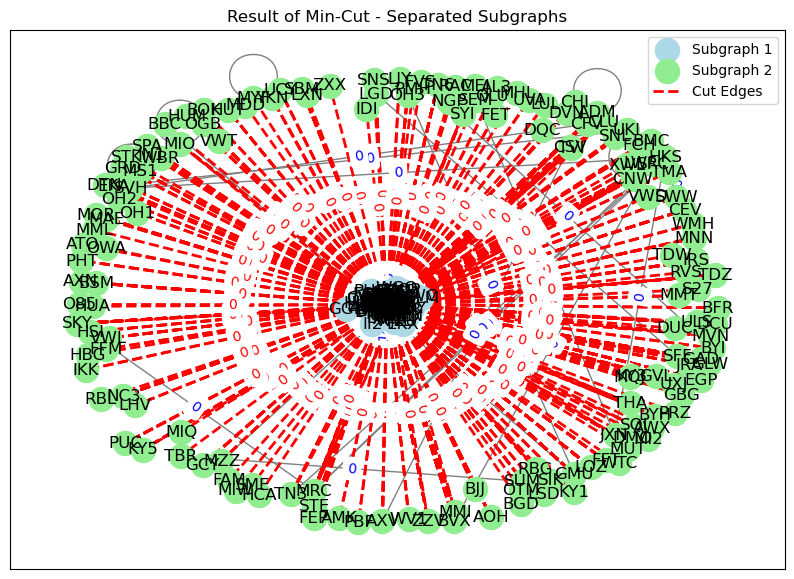

Cut edges: [('JRB', 'JRA'), ('PDT', 'LGD'), ('PDT', 'SFF'), ('MFD', 'SKY'), ('RFD', 'CLU'), ('RFD', 'DVN'), ('RFD', 'GVL'), ('RFD', 'IRS'), ('RFD', 'JXN'), ('RFD', 'OH2'), ('RFD', 'PMH'), ('RFD', 'MVN'), ('RFD', 'RVS'), ('FAR', 'VWL'), ('PIA', 'MVN'), ('PIA', 'SUM'), ('FSM', 'CLU'), ('FSM', 'MRC'), ('FSM', 'SBM'), ('BOS', 'ADM'), ('DFW', 'CHI'), ('DFW', 'CNW'), ('DFW', 'ADM'), ('DFW', 'MRC'), ('DFW', 'HKS'), ('JMS', 'VWL'), ('STL', 'CLU'), ('STL', 'HKS'), ('STL', 'IRS'), ('STL', 'JXN'), ('STL', 'LOZ'), ('STL', 'MRC'), ('STL', 'SBM'), ('STL', 'ADM'), ('STL', 'AXV'), ('STL', 'FAM'), ('STL', 'MIO'), ('STL', 'MVN'), ('STL', 'SVH'), ('STL', 'VWT'), ('SAT', 'ADM'), ('SAT', 'CLU'), ('SAT', 'CNW'), ('SAT', 'EGP'), ('SAT', 'MRC'), ('SAT', 'NGP'), ('SAT', 'UVA'), ('BTV', 'GMU'), ('BTV', 'LWF'), ('BTV', 'SKY'), ('ATW', 'BVX'), ('ATW', 'STE'), ('LMT', 'RBG'), ('RIC', 'IRS'), ('ANC', 'CHI'), ('ANC', 'CNW'), ('ANC', 'MDD'), ('BGS', 'BYH'), ('PAH', 'JXN'), ('RDD', 'EKA'), ('RDD', 'UKI'), ('GSP', 'GMU

In [42]:
# finding the min-cut
cut_edges, subgraph1, subgraph2, max_flow, cut_weight = ds.edmonds_karp_min_cut_custom(G_no_dir, source, sink)

# representing the graph with the cutted edges and the two subgraphs colored in different ways
ds.visualize_cut_result(G_no_dir, cut_edges, subgraph1, subgraph2)
print("Cut edges:", cut_edges)
print("Subgraph 1:", subgraph1)
print("Subgraph 2:", subgraph2)
print("Max flow:", max_flow)
print("Cut weight:", cut_weight)

In this case the smallest cut actually coincides with the maxflow, and we obtain two separate subgraphs with the minimum cost, 0. Two distinct subgraphs have been created, which are distinguished by two different colors. To verify the correct functioning of our algorithm, let's test it on a simpler graph.

So we perform a test on a smaller and more visible graph, in order to understand the correct functioning of our algorithm.

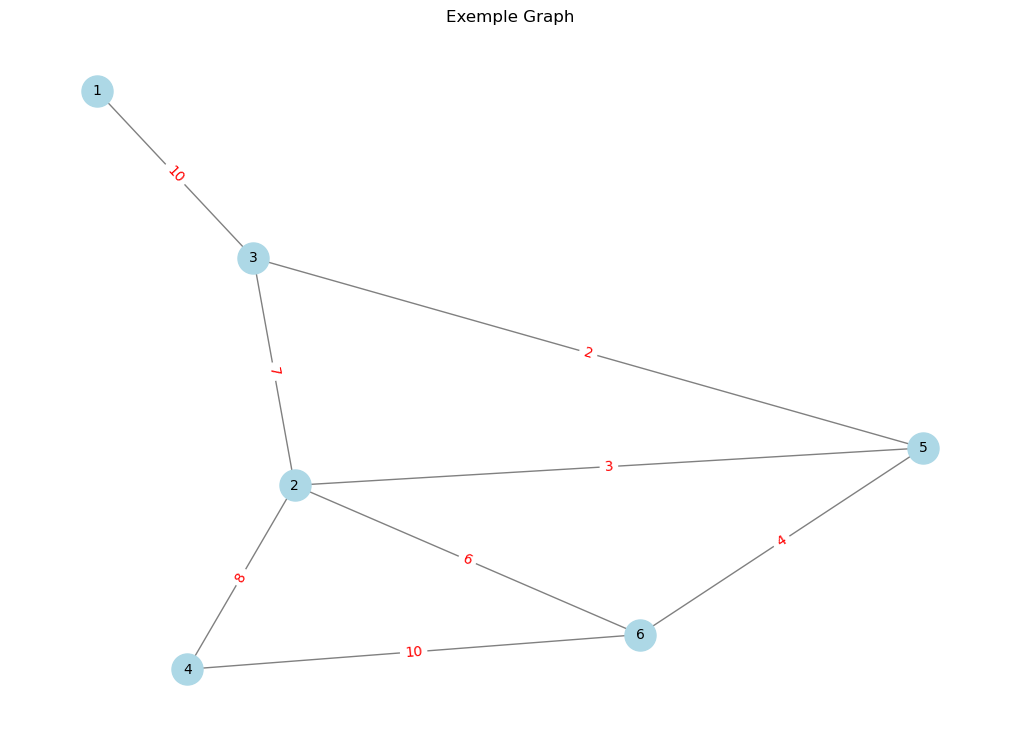

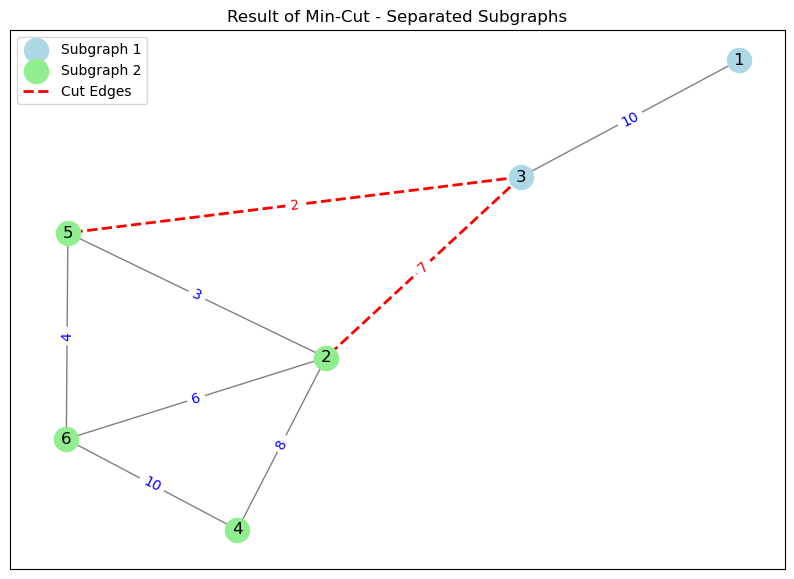

Cut edges: [(3, 2), (3, 5)]
Subgraph 1: {1, 3}
Subgraph 2: {2, 4, 5, 6}
Max flow: 9
Cut weight: 9


In [19]:

G_test = ds.create_test_graph()

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_test, k=0.15)  
nx.draw(
    G_test,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)

edge_labels = nx.get_edge_attributes(G_test, "weight")  
nx.draw_networkx_edge_labels(G_test, pos, edge_labels=edge_labels, font_color="red")
plt.title("Exemple Graph")
plt.show()

cut_edges, subgraph1, subgraph2, max_flow, cut_weight = ds.edmonds_karp_min_cut_custom(G_test, source=1, sink=6)


ds.visualize_cut_result(G_test, cut_edges, subgraph1, subgraph2)
print("Cut edges:", cut_edges)
print("Subgraph 1:", subgraph1)
print("Subgraph 2:", subgraph2)
print("Max flow:", max_flow)
print("Cut weight:", cut_weight)

In this case the algorithm works and the cut found seems to be optimal.

However, surely by changing the start and end nodes other cuts inside the graph are found, some better and some worse. Despite this, in the example of the main graph, a cut with a weight of 0 was found. So, surely even if there are other cuts that divide the graph into two subgraphs that cost 0, the one found remains one of the best options like all the others.

# 5.

In [64]:
sc.stop()

In [ ]:
from pyspark import SparkContext, SparkConf
from datetime import datetime

# Initialize Spark Context
conf = SparkConf().setAppName("ConnectedComponentsMapReduce").setMaster("local[*]")
sc = SparkContext(conf=conf)

# Sample flight data
flight_data = [
    ("JFK", "LAX", "2023-01-01"),
    ("LAX", "ORD", "2023-01-02"),
    ("ORD", "ATL", "2023-01-03"),
    ("ATL", "MIA", "2023-01-04"),
    ("MIA", "JFK", "2023-01-05"),
    ("SEA", "PDX", "2023-01-06"),
    ("PDX", "SFO", "2023-01-07"),
]

# Inputs
start_date = "2023-01-01"
end_date = "2023-01-05"

# Helper function to parse dates
def parse_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

# Filter flights based on the date range
filtered_flights = [
    (src, dest) for src, dest, date in flight_data
    if parse_date(start_date) <= parse_date(date) <= parse_date(end_date)
]

# Create RDD from filtered flights
edges_rdd = sc.parallelize(filtered_flights + [(dest, src) for src, dest in filtered_flights])

# Step 1: Map each airport to itself
nodes_rdd = edges_rdd.flatMap(lambda edge: [(edge[0], edge[0]), (edge[1], edge[1])])

def update_component(node, neighbors):
    # Filter out None values in neighbors
    valid_neighbors = [neighbor for neighbor in neighbors if neighbor is not None]
    # Return the smallest component ID
    return min(valid_neighbors) if valid_neighbors else node

def propagate_components(edges_rdd, iterations=10):
    # Start by mapping each node to itself
    components = edges_rdd.flatMap(lambda edge: [(edge[0], edge[0]), (edge[1], edge[1])])

    for _ in range(iterations):
        # Join components with edges
        neighbors_rdd = edges_rdd.join(components).map(lambda x: (x[1][0], x[1][1]))

        # Reduce by key to find the smallest component for each node
        components = neighbors_rdd.groupByKey().mapValues(lambda neighbors: update_component(None, list(neighbors)))

    return components

# Run the connected component propagation
components_rdd = propagate_components(edges_rdd)

# Step 3: Count connected components and identify largest
connected_components = components_rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(len)
largest_component = connected_components.sortBy(lambda x: x[1], ascending=False).first()

# Output Results
print("Number of connected components:", connected_components.count())
print("Size of each connected component:", connected_components.collect())
print("Largest connected component:", largest_component)

Number of connected components: 1
Size of each connected component: [('ATL', 5)]
Largest connected component: ('ATL', 5)


In [ ]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("ConnectedComponentsGraphFrames") \
    .config("spark.jars", "/content/graphframes-0.8.2-spark3.0-s_2.12.jar") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

# Sample filtered flights
filtered_flights = [
    ("JFK", "LAX"),
    ("LAX", "ORD"),
    ("ORD", "ATL"),
    ("ATL", "MIA"),
    ("MIA", "JFK"),
]

# Create DataFrames for edges and vertices
edges_df = spark.createDataFrame(filtered_flights, ["src", "dst"])
vertices_df = edges_df.selectExpr("src as id").union(edges_df.selectExpr("dst as id")).distinct()

# Create GraphFrame
graph = GraphFrame(vertices_df, edges_df)

# Find connected components
result = graph.connectedComponents()
result.show()

# Analyze connected components
graph_components = result.groupBy("component").count().orderBy("count", ascending=False)
graph_largest_component = graph_components.first()

print("Number of connected components (GraphFrames):", graph_components.count())
print("Size of the largest connected component (GraphFrames):", graph_largest_component)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling o636.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


# **ALGORITHMIC QUESTION**

In [ ]:
import heapq
from collections import defaultdict

def find_cheapest_price_advanced(n, flights, src, dst, k):
    # Create an adjacency list for the graph
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Dynamic Programming table
    dp = [[float('inf')] * (k + 2) for _ in range(n)]
    dp[src][0] = 0  # Cost to reach the source city with 0 stops is 0

    # Min-Heap for priority queue traversal: (current_cost, current_city, stops_so_far)
    heap = [(0, src, 0)]

    while heap:
        current_cost, current_city, stops_so_far = heapq.heappop(heap)

        # If destination is reached, return the cost
        if current_city == dst:
            return current_cost

        # If stops exceed the limit, skip further exploration
        if stops_so_far > k:
            continue

        # Explore neighbors
        for neighbor, price in graph[current_city]:
            new_cost = current_cost + price

            # If the new cost is better than the current best cost in dp for this neighbor and stop level
            if new_cost < dp[neighbor][stops_so_far + 1]:
                dp[neighbor][stops_so_far + 1] = new_cost
                heapq.heappush(heap, (new_cost, neighbor, stops_so_far + 1))

    # If no valid path is found, return -1
    return -1 if min(dp[dst]) == float('inf') else min(dp[dst])

# Example usage
n = 4
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]
src = 0
dst = 3
k = 1

print(find_cheapest_price_advanced(n, flights, src, dst, k))  # Output: 700

700


## Algorithm Efficiency Analysis

This algorithm combines dynamic programming with a priority queue to efficiently determine the cheapest route in a graph while adhering to constraints on the maximum number of stops. It uses a `dp` table to track the minimum costs for reaching each city at various stop levels, ensuring systematic cost updates. A min-heap (priority queue) is employed to prioritize exploration of cheaper paths, allowing the algorithm to focus on more promising routes first. The graph is represented as an adjacency list, enabling efficient lookups for neighboring cities and their respective costs. Together, these techniques minimize redundant computations and reduce the likelihood of exploring inefficient paths, leading to a more streamlined process.

For large graphs with over 100 cities, the algorithm performs well due to its reliance on the priority queue for cost-based path selection, ensuring that only relevant routes are examined. The `dp` table's space requirements scale with the number of cities and stops, which is manageable under most practical conditions. However, if the stop limit grows too large, the algorithm may approach the complexity of exhaustive search, potentially reducing its efficiency for very dense graphs. In such cases, further optimizations like graph preprocessing or heuristic-based pruning could be applied. Overall, this approach offers a strong balance between computational efficiency and memory usage, making it well-suited for moderately complex and large-scale graphs.


## Optimized Algorithm for Larger Graphs

The optimized algorithm uses a fixed-size priority queue and dynamic programming to efficiently handle large graphs, even with more than 100 cities. The priority queue ensures that only the most promising paths are explored by prioritizing those with the lowest current cost, and the dynamic programming table tracks the best cost for each city at every stop level. This eliminates redundant calculations and avoids revisiting less optimal paths. Additionally, the algorithm includes an optional heuristic to estimate the remaining cost to the destination, which helps terminate exploration of paths unlikely to yield better results. These optimizations work together to minimize both computational overhead and memory usage, making the algorithm scalable for larger graphs and dense flight networks.

In terms of complexity, the algorithm builds the adjacency list in
𝑂
(
𝐸
)
O(E), where
𝐸
E is the number of flights. The heap operations, combined with dynamic programming updates, give it a total time complexity of
𝑂
(
𝐸
⋅
(
𝑘
+
1
)
⋅
log
⁡
𝑉
)
O(E⋅(k+1)⋅logV), where
𝑘
k is the maximum allowed stops and
𝑉
V is the number of cities. The space complexity is
𝑂
(
𝐸
+
𝑉
⋅
𝑘
)
O(E+V⋅k), accounting for the adjacency list, the priority queue, and the dynamic programming table. These properties make the algorithm efficient for graphs with a large number of cities and flights, provided the stop limit remains moderate. Overall, the method strikes a practical balance between time and space efficiency, ensuring suitability for real-world scenarios with moderately large and complex graphs.

In [ ]:
Function find_cheapest_price_optimized(n, flights, src, dst, k):
    1. Create an adjacency list `graph`:
       For each flight [u, v, cost] in flights:
           graph[u].append((v, cost))

    2. Initialize a `dp` table:
       dp[v][i] = INF for all cities v and stops i, where i ∈ [0, k+1]
       dp[src][0] = 0  # Cost to reach source city with 0 stops is 0

    3. Initialize a priority queue `heap`:
       Push (0, src, 0)  # (cost_so_far, current_city, stops_so_far)

    4. While `heap` is not empty:
        Pop (current_cost, current_city, stops_so_far) from `heap`

        If current_city == dst:
            Return current_cost

        If stops_so_far > k:
            Continue  # Skip if stops exceed the limit

        For each (neighbor, price) in graph[current_city]:
            new_cost = current_cost + price

            If new_cost < dp[neighbor][stops_so_far + 1]:
                dp[neighbor][stops_so_far + 1] = new_cost
                Push (new_cost, neighbor, stops_so_far + 1) to `heap`

    5. Return -1 if no valid route is found (i.e., min(dp[dst]) == INF)

## Optimized Algorithm from an LLM (ChatGPT)

ChatGPT's Solution:

In [ ]:
from collections import defaultdict, deque

def find_cheapest_price(n, flights, src, dst, k):
    # Create an adjacency list for the graph
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Use a priority queue (BFS with cost tracking)
    queue = deque([(src, 0, 0)])  # (current_city, cost_so_far, stops_so_far)
    min_cost = float('inf')

    while queue:
        current_city, cost_so_far, stops_so_far = queue.popleft()

        # If destination is reached within constraints
        if current_city == dst:
            min_cost = min(min_cost, cost_so_far)
            continue

        # If stops exceed the limit, skip this route
        if stops_so_far > k:
            continue

        # Explore neighbors
        for neighbor, price in graph[current_city]:
            if cost_so_far + price < min_cost:  # Only consider if it might improve the result
                queue.append((neighbor, cost_so_far + price, stops_so_far + 1))

    return min_cost if min_cost != float('inf') else -1

# Example usage
n = 4
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]
src = 0
dst = 3
k = 1

print(find_cheapest_price(n, flights, src, dst, k))
